# Meteo 515 – Assignment 4 – EOF analysis¶

In [1]:
from __future__ import division, print_function
#from collections import OrderedDict
from glob import glob
#from itertools import chain

import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
#import scipy.optimize as so
#import scipy.stats as ss
#import sklearn as skl
import statsmodels.api as sm
import xarray as xr

In [2]:
plt.style.use('seaborn-darkgrid') # 'bmh', ggplot', 'seaborn-darkgrid'
%matplotlib notebook

## Load the data

### First, create container for the results that also does the EOF calculation
$\renewcommand{\vec}[1]{\mathbf{#1}}$
We can get the eigenvectors (EOFs), corresponding eigenvalues, and the principle component vectors (PCs) all at once by determining the singular value decomposition (SVD) of the data matrix $\vec{X}$. 
$$
\vec{X} = \vec{U} \vec{\Sigma} \vec{V}^T
$$

* $\vec{U}$: columns are called the right singular vectors
* $\vec{\Sigma}$: diagonal matrix of the singular values of $\vec{X}$
* $\vec{V}^T$: columns are called the left singular vectors

The EOFs / principle directions are given from this decomposition as $\vec{V}$, the eigenvalues of the covariance matrix as $\lambda_i = s_i^2 / (n-1)$, and the principle components ("scores") by $\vec{U} \vec{\Sigma} = \vec{X} \vec{V}$. These definitions assume rows are samples and and columns are variables. To accomodate this we transpose our $\vec{X}$, though we could instead keep the data matrix as is and simply switch the two definitions, e.g., EOFs = $\vec{X} \vec{V}$.

In [3]:
class o(object):
    """hw4 results obj
    for one dataset, the things we want to save"""
    def __init__(self, fname, ID, dset,
                 ):
        self.fname = fname
        self.ID = ID
        self.dset = dset
        
        self.calc_eofs()
        
        
    def calc_eofs(self):
        """calc EOFs
        note that SVD method may fail. should have a fallback...
        """
        X = self.dset['data'].values.T
        #print(X.shape)
        U, s, V_T = np.linalg.svd(X)
        S = np.diag(s)  # supposed to be m x n diagonal matrix not square, where X is m x n
        #print(U.shape, S.shape, V_T.shape)
        n = S.shape[0]
        V = V_T.T
        self.evecs = V #U @ S #V
        self.evals = s**2 / (n-1)
        self.pcs   = X @ V #U @ S
        
        self.evals_sum = self.evals.sum()
        self.rsqd_expl = self.evals / self.evals_sum
        
        imax = np.where(np.cumsum(self.rsqd_expl) >= 0.91)[0][0]
        self.n_retain = imax + 1 if imax <= 6 else 8

### Now apply to the datasets

In [4]:
files = sorted(glob('./data/sine_wave_data*.nc'))
lbls = ['dset {:d}'.format(x) for x in range(1, len(files)+1)]

os = []
for fname, l in zip(files, lbls):
    os.append(o(fname, l, xr.open_dataset(fname)))

## a) Plot standardized principle components (PCs)

Dividing a principle component vector by the square-root of corresponding eigenvalue of the covariance matrix normalizes it, i.e., giving a variance of 1.  

In [5]:
# Some settings used in other plots
colors = plt.cm.Dark2(np.linspace(0, 1, 8))[:8]
hspace = 0.3
figsize = (8, 7)
leg_fs = 8

<IPython.core.display.Javascript object>


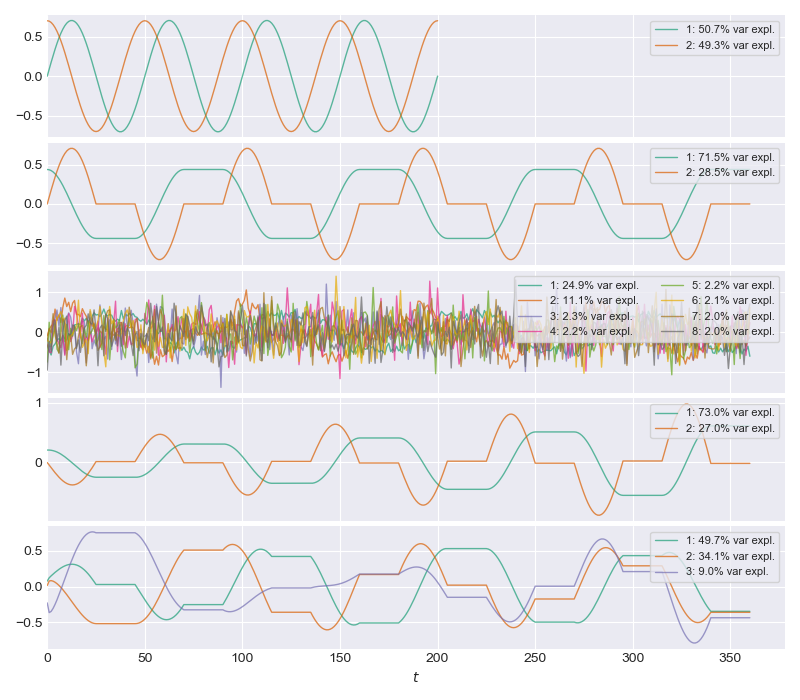

In [6]:
f1, aa = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='PCs')

for i, o in enumerate(os):
    
    a = aa.flat[i]
    
    evals = o.evals[:o.n_retain]
    pcs = o.pcs[:,:o.n_retain]
    pcts = o.rsqd_expl[:o.n_retain] * 100
    
    for j in range(pcs.shape[1]):
        s = '{:d}: {:.1f}% var expl.'.format(j+1, pcts[j])
        a.plot(pcs[:,j]/np.sqrt(evals[j]), 
               c=colors[j], lw=1.0, alpha=0.7, label=s)
    
    ncol = 1 if o.n_retain <= 4 else 2
    a.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)

aa[0].set_xlim(left=0)
aa[-1].set_xlabel('$t$')

f1.tight_layout(h_pad=hspace);

**Discussion:**

In order, these are descriptions of the data that the Prof created for this assignment:

1. Propagating sine wave
2. Propagating sine wave that stalls when it is either a positive or negative sine curve
3. Propagating sine wave with stalling and additional random noise
4. Propagating sine wave with stalling and increasing amplitude with time
5. Propagating sine wave with stalling and increasing frequency with time

We can see easily all of these features in the above time series of the PCs.

## b) Regress the standardized PCs onto the original data

<IPython.core.display.Javascript object>


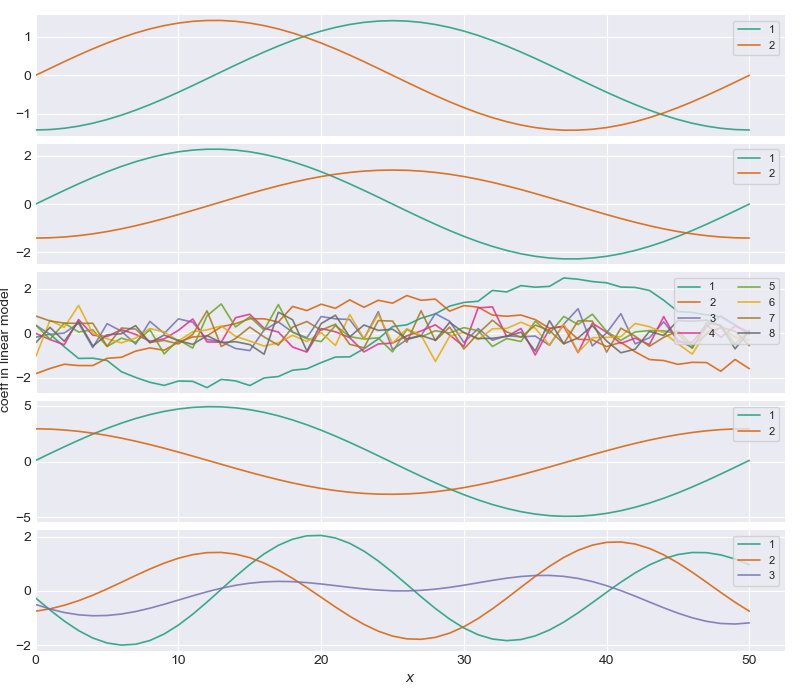

<IPython.core.display.Javascript object>


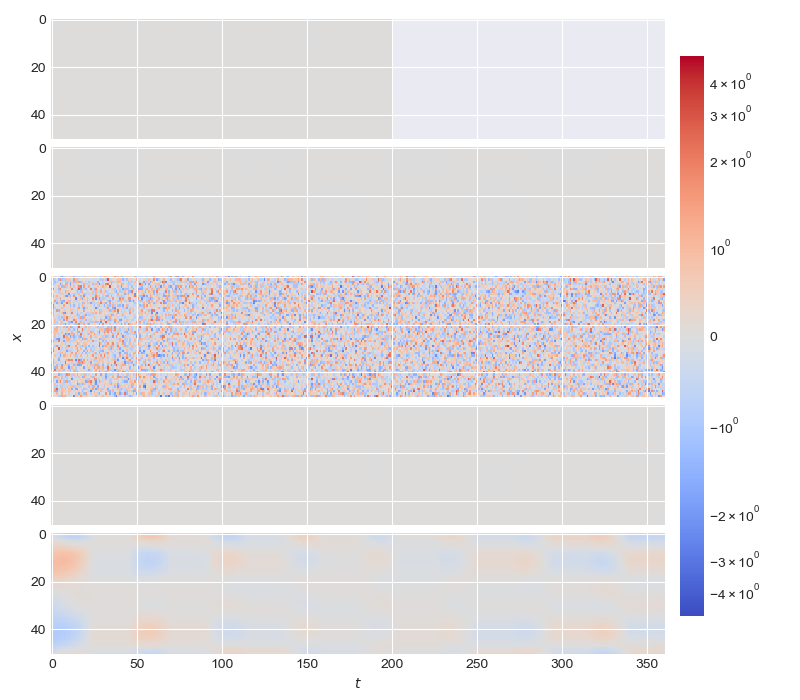

In [7]:
f2, aa = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='MLR_PCs_slopes')
f2b, aab = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='MLR_PCs_resid')

fits_coeffs_all = []
for i, o in enumerate(os):
    
    a = aab.flat[i]
    a2 = aa.flat[i]

    Y = o.dset.data.values 
    X = o.pcs[:,:o.n_retain] / np.sqrt(o.evals[:o.n_retain])
    
    #> run MLR for the ts at each x position
    fits = []
    for j in range(Y.shape[0]):
        y = Y[j,:]
        fit = sm.OLS(y, X).fit()  # model fit (coefficients etc.) for the least-squares soln
        fits.append(fit)
    resids = np.array([fit.resid for fit in fits])
    slopes = np.array([fit.params for fit in fits])
    fits_coeffs_all.append(slopes)
    
    #> plot slopes
    for j in range(slopes.shape[1]):
        s = '{:d}'.format(j+1)
        a2.plot(slopes[:,j], 
               c=colors[j], lw=1.2, alpha=0.85, label=s)
        
    ncol = 1 if o.n_retain <= 4 else 2
    a2.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)        
            
    #> plot residuals as x vs t map
    im = a.imshow(resids, aspect='auto',
                  norm=mplcolors.SymLogNorm(linthresh=2, linscale=1.0, vmin=-5.0, vmax=5.0),
                  cmap='coolwarm')

#f2b.colorbar(im, orientation="vertical", pad=0.2)
f2b.tight_layout(rect=[0.02, 0.02, 0.85, 1.0], h_pad=hspace)  # call before adding new ax to avoid warning
cbaxes = f2b.add_axes([0.85, 0.12, 0.03, 0.8]) 
cb = f2b.colorbar(im, cax=cbaxes) 

aa[0].set_xlim(left=0)
aa[-1].set_xlabel('$x$')
f2.text(0., 0.5, 'coeff in linear model', 
        rotation='vertical', va='center')

aab[-1].set_xlabel('$t$')
aab[2].set_ylabel('$x$')

f2.tight_layout(h_pad=hspace);

**Discussion:**



## c) Plot the EOFs scaled by the square-root of their eigenvalue


<IPython.core.display.Javascript object>


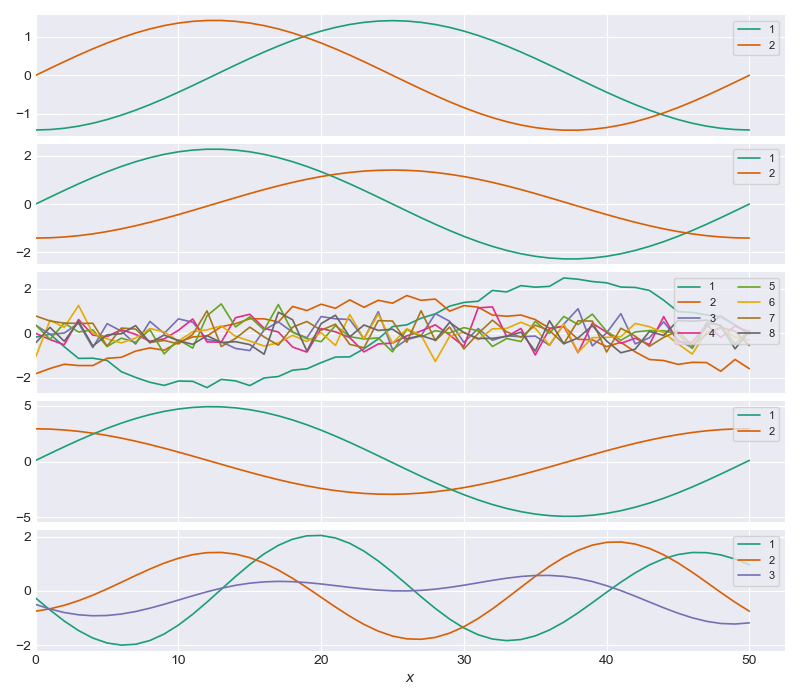

<IPython.core.display.Javascript object>


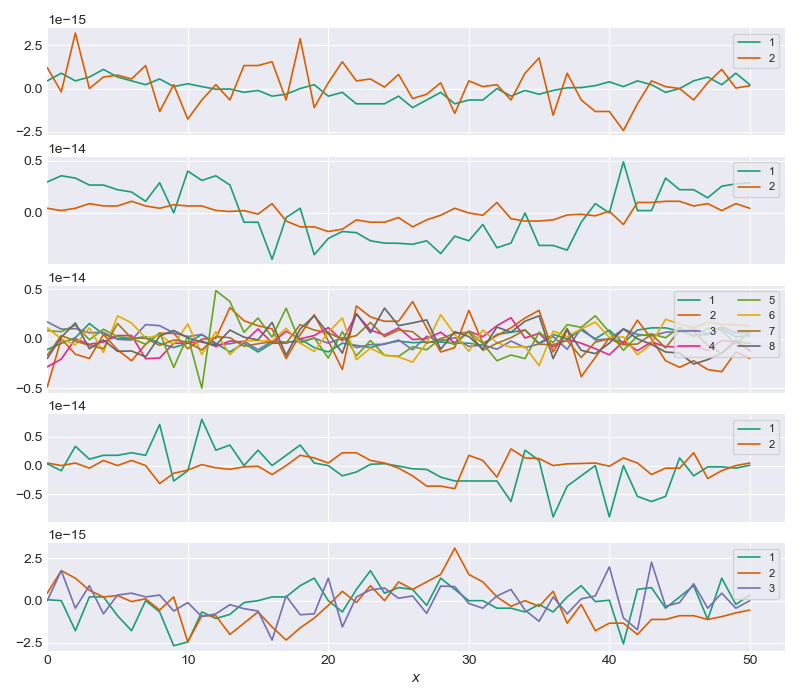

In [8]:
f3, aa = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='scaled_EOFs')

for i, o in enumerate(os):
    
    a = aa.flat[i]
    
    eofs = o.evecs[:,:o.n_retain]
    evals = o.evals[:o.n_retain]
    for j in range(eofs.shape[1]):
        s = '{:d}'.format(j+1)
        a.plot(eofs[:,j]*np.sqrt(evals[j]), c=colors[j], lw=1.2, label=s)

    ncol = 1 if o.n_retain <= 4 else 2
    a.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)        

aa[0].set_xlim(left=0)
aa[-1].set_xlabel('$x$')

f3.tight_layout(h_pad=hspace)


f3b, aab = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='scaled_EOFs_minus_MLR_PCs')

for i, o in enumerate(os):
    
    a = aab.flat[i]
    
    eofs = o.evecs[:,:o.n_retain]
    evals = o.evals[:o.n_retain]
    for j in range(eofs.shape[1]):
        s = '{:d}'.format(j+1)
        a.plot(eofs[:,j]*np.sqrt(evals[j]) - fits_coeffs_all[i][:,j], c=colors[j], lw=1.2, label=s)

    ncol = 1 if o.n_retain <= 4 else 2
    a.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)        

aab[0].set_xlim(left=0)
aab[-1].set_xlabel('$x$')

f3b.tight_layout(h_pad=hspace);

**Discussion:**

At first glance the plot is identical to the one in (b). In fact, if we look at the 2nd plot, where we subtracting the (b) plot from the (c) plot, we see that the differences are approaching machine precision. 